In [1]:
import numpy as np
import scipy
import scipy.stats
import pandas as pd
import astropy.units as u
import sunpy.map
import sunpy.visualization.colormaps as cm
import cv2
import skimage
import glob
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import random

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers

import autoenc_model as aem
import data_generator as dg
import utils

2023-04-06 22:33:40.786718: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
noise_filter = True

In [3]:
# Read images
data_files = glob.glob("data/composite_data/2016*.npy")

if noise_filter:
    noise_imgs = []
    with open("noisy_193A.csv", "r") as f:
        noise_imgs = f.readlines()
    
    noise_imgs = list(map(lambda x: x.strip(), noise_imgs))

    noise_imgs = [x.split("/")[-1].replace(".fits", ".npy") for x in noise_imgs]

    data_files = [f for f in data_files if f.split("/")[-1] not in noise_imgs]

data_matrix = np.empty([len(data_files),100,360,3])

for idx, data_file in enumerate(data_files):
    data_point = np.load(data_file)
    if data_point.shape[0] == 100:
        data_matrix[idx] = data_point
    else:
        print(data_point.shape, data_file)

data_matrix[:,:,:,0] = np.clip(data_matrix[:,:,:,0], 0, 5000)
data_matrix[:,:,:,1] = np.clip(data_matrix[:,:,:,1], 0, 3000)
data_matrix[:,:,:,2] = np.clip(data_matrix[:,:,:,2], -400, 400)

min_values = np.nanmin(np.nanmin(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
max_values = np.nanmax(np.nanmax(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)

rg = max_values - min_values

rg = np.fmax(rg, 1e-4)

data_matrix_norm = (data_matrix-min_values) / rg

# Normalize HMI magnetogram data differently
hmi_max_values = np.nanmax(np.nanmax(np.abs(data_matrix[:,:,:,2]), axis=2, keepdims=True), axis=1, keepdims=True)

data_matrix_norm[:,:,:,2] = ((data_matrix[:,:,:,2] / hmi_max_values) + 1)/2

data_matrix_norm[np.isnan(data_matrix_norm)] = 0

# data_matrix_norm = (data_matrix_norm*2)-1

input_train, input_test = train_test_split(data_matrix_norm, test_size=0.25)

utils.range_tuple(data_matrix_norm)

2800
2463
(360, 100, 3) data/composite_data/2016-02-01T03-34-35.npy


/tmp/ipykernel_98874/1683324495.py:30: RuntimeWarning: All-NaN slice encountered
  min_values = np.nanmin(np.nanmin(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
/tmp/ipykernel_98874/1683324495.py:31: RuntimeWarning: All-NaN slice encountered
  max_values = np.nanmax(np.nanmax(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
/tmp/ipykernel_98874/1683324495.py:40: RuntimeWarning: All-NaN slice encountered
  hmi_max_values = np.nanmax(np.nanmax(np.abs(data_matrix[:,:,:,2]), axis=2, keepdims=True), axis=1, keepdims=True)
/tmp/ipykernel_98874/1683324495.py:42: RuntimeWarning: invalid value encountered in divide
  data_matrix_norm[:,:,:,2] = ((data_matrix[:,:,:,2] / hmi_max_values) + 1)/2


(0.0, 1.0)

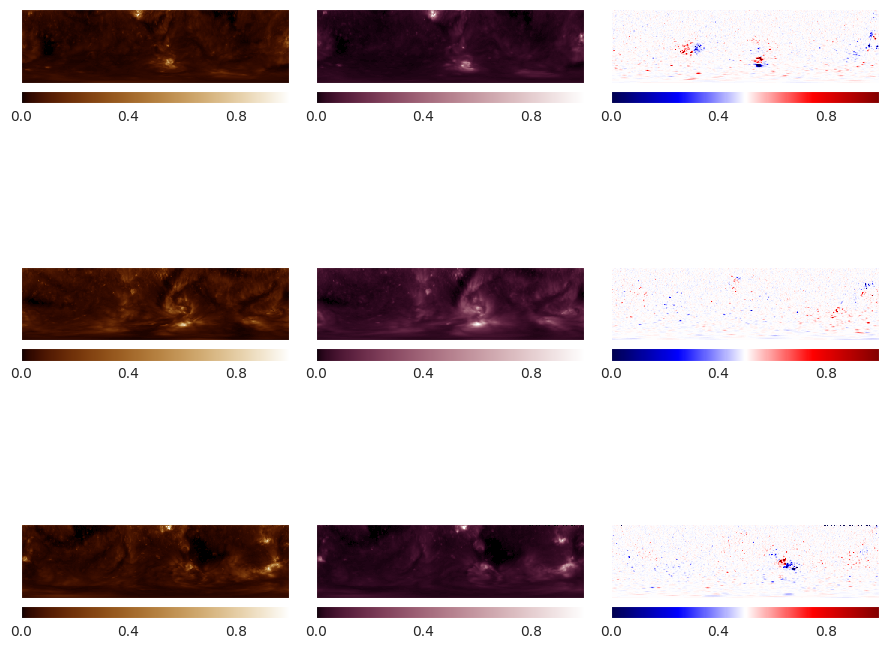

In [4]:
img_amount = 3

image_list = []
for data_image in data_matrix_norm[:img_amount]:
    for channel in data_image.transpose(2,0,1):
        image_list.append(channel)

isns.ImageGrid(image_list, cmap=["sdoaia193", "sdoaia211", "seismic"]*img_amount, orientation="h", vmin=0, vmax=1)

(200, 200) (100, 360)


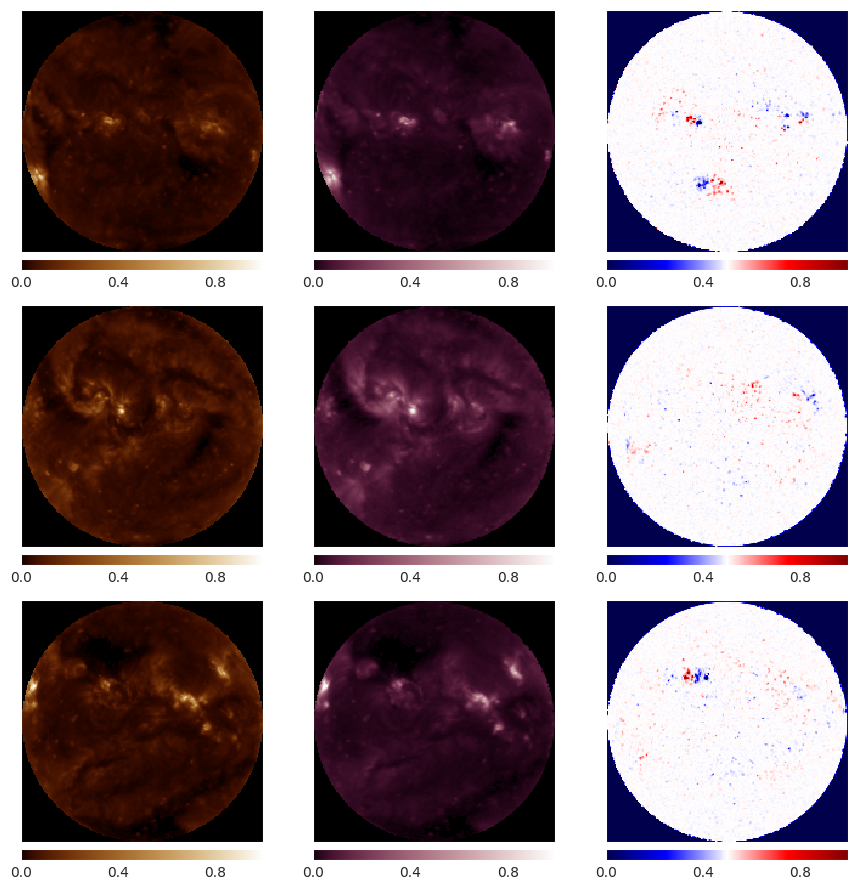

In [5]:
print(utils.polar_linear(image_list[0]).shape, image_list[0].shape)
ax = isns.ImageGrid(image_list.copy(), col_wrap=3, cmap=["sdoaia193", "sdoaia211", "seismic"]*img_amount, map_func=utils.polar_linear, orientation="h", vmin=0, vmax=1)

In [6]:
import math
from scipy.ndimage import map_coordinates

def polar_linear_numpy(input_img):
    origin = np.array(output.shape[[1,2]])/2 - 0.5

    _, out_h, out_w, _ = input_img.shape
    ys, xs = np.mgrid[:out_h, :out_w] - origin
    rs = np.sqrt(ys**2 + xs**2)
    ts = np.arccos(xs/rs)
    ts[:, ys<0] = np.pi*2 - ts[:, ys<0]
    ts *= (img.shape[2]-1)/(np.pi*2)

    result = map_coordinates(img, (rs, ts), order=1, cval=0)

    return np.flip(result, axis=1)


def polar_transform_loss(out_true_polar, out_pred_polar, loss_name):

    out_true_lin = tf.numpy_function(polar_transform_loss, [out_true_polar], tf.float64)
    out_pred_lin = tf.numpy_function(polar_transform_loss, [out_pred_polar], tf.float64)

    return keras.losses.get(loss_name)(out_true_lin, out_pred_lin)

In [7]:
latent_size = 64
# optimizer = keras.optimizers.Adam(learning_rate=0.001)
# optimizer = keras.optimizers.SGD(learning_rate=0.01)
optimizer = keras.optimizers.RMSprop(learning_rate=0.001)

loss_fn = "mse"
# loss_fn = lambda x, y: polar_transform_loss(x, y, "mse")

autoencoder, encoder, decoder = aem.gen_xception_autoenc_3c(latent_size, optim=optimizer, loss=loss_fn)

2023-04-06 22:33:56.063736: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-06 22:33:56.081133: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-06 22:33:56.081348: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 360, 3  0           []                               
                                )]                                                                
                                                                                                  
 cylindrical_padding2d (Cylindr  (None, 100, 366, 3)  0          ['input_1[0][0]']                
 icalPadding2D)                                                                                   
                                                                                                  
 conv2d (Conv2D)                (None, 49, 182, 32)  864         ['cylindrical_padding2d[0][0]']  
                                                                                              

In [8]:
n_epochs = 100
batch_size = 36

history = autoencoder.fit(input_train, input_train, epochs=n_epochs,  validation_split=0.1, batch_size=batch_size)

Epoch 1/100


2023-04-06 22:34:05.538286: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-04-06 22:34:06.935902: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


47/47 [==============================] - 21s 206ms/step - loss: 0.0213 - mae: 0.0914 - val_loss: 0.0169 - val_mae: 0.0941
Epoch 2/100
47/47 [==============================] - 6s 128ms/step - loss: 0.0081 - mae: 0.0640 - val_loss: 0.0048 - val_mae: 0.0384
Epoch 3/100
47/47 [==============================] - 6s 130ms/step - loss: 0.0064 - mae: 0.0561 - val_loss: 0.0073 - val_mae: 0.0620
Epoch 4/100
47/47 [==============================] - 6s 129ms/step - loss: 0.0053 - mae: 0.0491 - val_loss: 0.0049 - val_mae: 0.0415
Epoch 5/100
47/47 [==============================] - 6s 129ms/step - loss: 0.0047 - mae: 0.0435 - val_loss: 0.0045 - val_mae: 0.0388
Epoch 6/100
47/47 [==============================] - 6s 128ms/step - loss: 0.0043 - mae: 0.0388 - val_loss: 0.0044 - val_mae: 0.0377
Epoch 7/100
47/47 [==============================] - 6s 128ms/step - loss: 0.0041 - mae: 0.0378 - val_loss: 0.0046 - val_mae: 0.0393
Epoch 8/100
47/47 [==============================] - 6s 130ms/step - loss: 0.004

20/20 [==============================] - 2s 70ms/step - loss: 0.0017 - mae: 0.0197


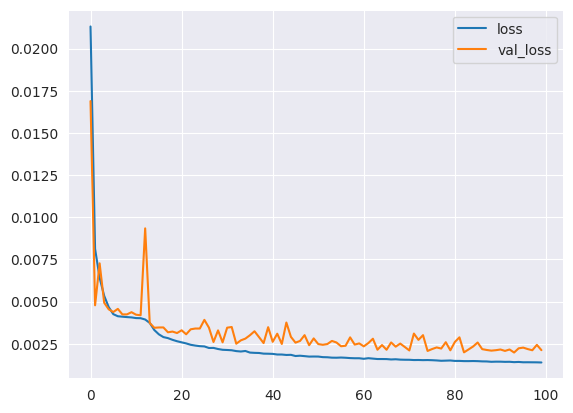

In [9]:
autoencoder.evaluate(input_test, input_test)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

(1, 100, 360, 3)


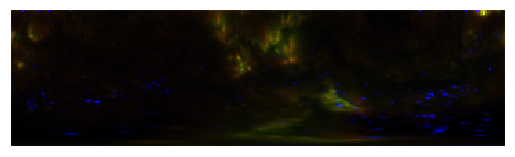

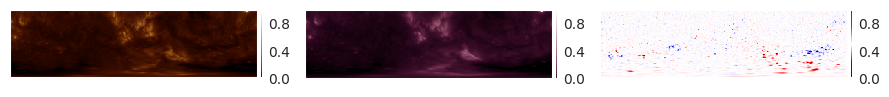

In [22]:
test_img = np.array(random.choices(input_test, k=1))
print(test_img.shape)

test_img_display = test_img[0].copy()
test_img_display[:,:,2] = np.abs((0.5 - test_img_display[:,:,2])*2)
isns.imgplot(test_img_display)
isns.rgbplot(test_img[0], cmap=["sdoaia193", "sdoaia211", "seismic"], vmin=0, vmax=1)

<AxesSubplot: >

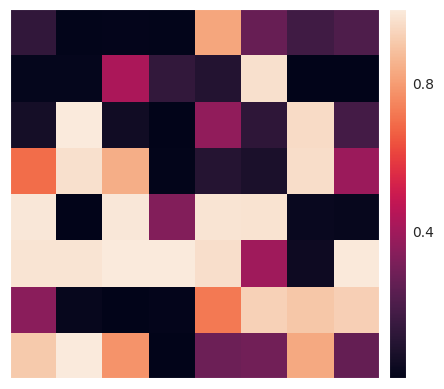

In [23]:
code = encoder(test_img)
# isns.imgplot(np.reshape(code[0], (6, 8)))
isns.imgplot(np.reshape(code[0], (8, 8)))

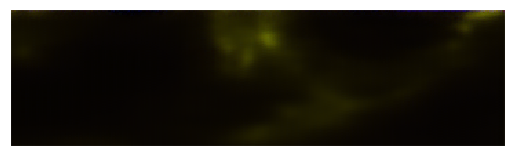

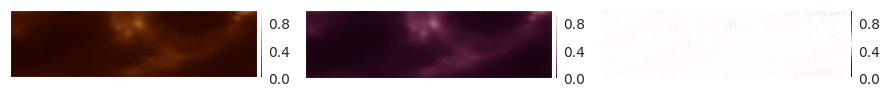

In [24]:
decoded = decoder(code)
# isns.imgplot(decoded[0])
decoded_display = np.copy(decoded[0])
decoded_display[:,:,2] = np.abs((0.5 - decoded_display[:,:,2])*2)
isns.imgplot(decoded_display)
isns.rgbplot(decoded[0], cmap=["sdoaia193", "sdoaia211", "seismic"], vmin=0, vmax=1)

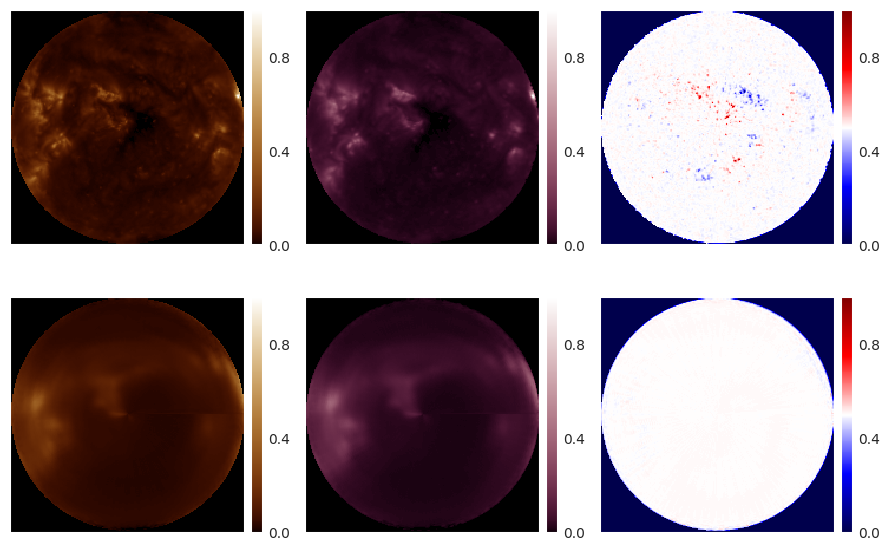

In [25]:
test_img_channels = [i for i in test_img[0].transpose(2,0,1)]

decoded_img_channels = [i for i in np.asarray(decoded[0]).transpose(2,0,1)]


isns.ImageGrid(test_img_channels+decoded_img_channels, cmap=["sdoaia193", "sdoaia211", "seismic"]*2, vmin=0, vmax=1, map_func=utils.polar_linear)